In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [35]:
import torch
from tst_info import TSTInfo
import yaml
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v1_demo.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]
signal_ratio = config["signal_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
fvt_models_dict = {seed: {} for seed in seeds}

hparam_filter = {
    "experiment_name": experiment_name,
}


hashes = TSTInfo.find(hparam_filter)
assert len(hashes) == 1
print("successfully loaded", hparam_filter)
hash = hashes[0]
tstinfo = TSTInfo.load(hash)


successfully loaded {'experiment_name': 'counting_test_v1_demo'}


In [36]:
def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

In [37]:
from events_data import EventsData
from dataset import SCDatasetInfo

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str):
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, bins, ax, **hist_kwargs):
    ax.hist(events.fvt_score[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(events.fvt_score[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(events.fvt_score[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

/tmp/ipykernel_1183995/262010544.py:40: RuntimeWarning: invalid value encountered in divide
  ax2.plot(x_points, hist_bg4b / hist_3b, "o-", label="bg4b/3b", color="red")


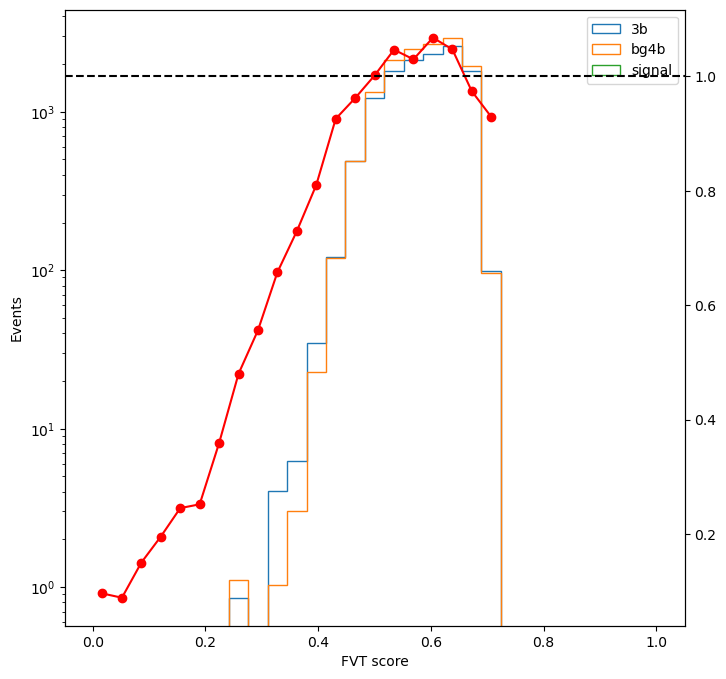

In [54]:
from fvt_classifier import FvTClassifier


signal_filename = tstinfo.hparams["signal_filename"]
scdinfo_tst = tstinfo.scdinfo_tst
events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
base_fvt_hash = tstinfo.base_fvt_tinfo_hash
fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
fvt_model.eval()
events_tst.set_model_scores(fvt_model)
CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
CR_model.eval()


SR_stats = tstinfo.SR_stats
SR_cut = tstinfo.SR_cut
in_SR = SR_stats >= SR_cut
ratio_4b = tstinfo.hparams["ratio_4b"]
probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
events_tst.reweight(
    np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))


bins_range = np.linspace(0, 1, 30)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
hist_events_by_labels(events_tst[in_SR], bins=bins_range, ax=ax)
ax.set_xlabel("FVT score")
ax.set_ylabel("Events")
ax.legend()
ax.set_yscale("log")

hist_bg4b, _ = np.histogram(events_tst.fvt_score[events_tst.is_bg4b], bins=bins_range, weights=events_tst.weights[events_tst.is_bg4b])
hist_3b, _ = np.histogram(events_tst.fvt_score[events_tst.is_3b], bins=bins_range, weights=events_tst.weights[events_tst.is_3b])
hist_signal, _ = np.histogram(events_tst.fvt_score[events_tst.is_signal], bins=bins_range, weights=events_tst.weights[events_tst.is_signal])

ax2 = ax.twinx()
x_points = bins_range[:-1] + np.diff(bins_range) / 2
ax2.plot(x_points, hist_bg4b / hist_3b, "o-", label="bg4b/3b", color="red")
ax2.axhline(1, color="black", linestyle="--")
plt.show()

In [49]:
hist_bg4b / hist_3b

/tmp/ipykernel_1183995/3045380311.py:1: RuntimeWarning: invalid value encountered in divide
  hist_bg4b / hist_3b


array([0.18181818, 0.21052632, 0.16494845, 0.24888889, 0.2578125 ,
       0.24825175, 0.34480122, 0.4261745 , 0.48930818, 0.57860781,
       0.64227183, 0.72248919, 0.85383653, 0.92674707, 1.0322131 ,
       1.19544118, 1.33737691, 1.61584   , 1.85949943, 1.95127701,
       1.87878788,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])

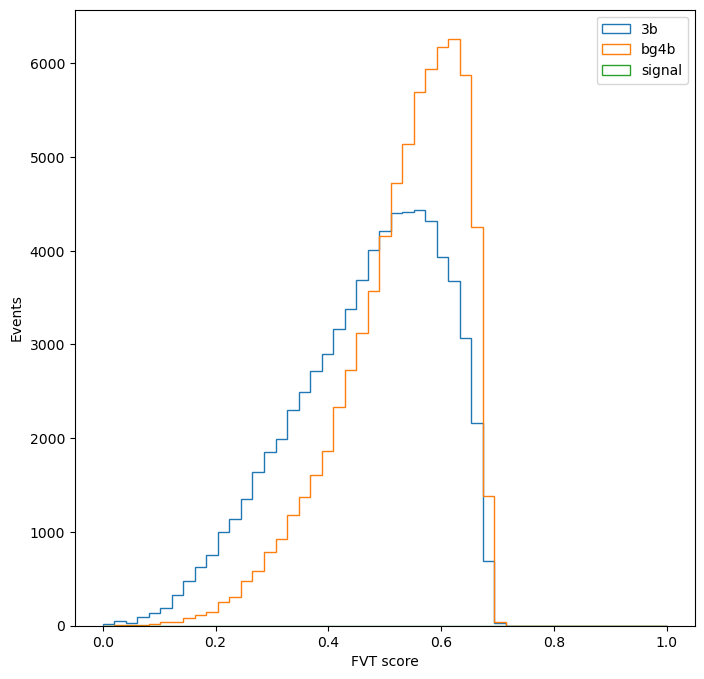

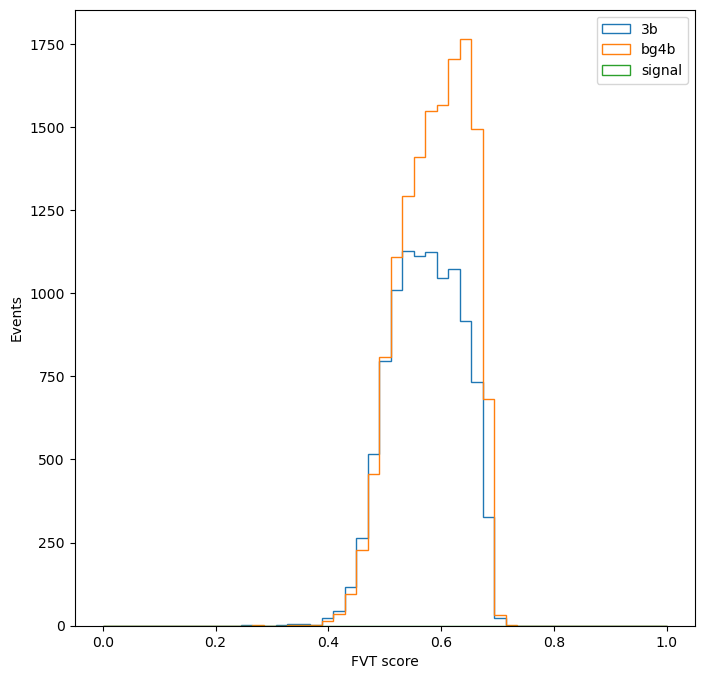